# Задача

# Введение
В Контуре мы много работаем с документами: арбитражные иски, госзакупки, исполнительные производства. В данном задании мы предлагаем вам сделать модель, которая поможет отделу госзакупок извлекать 
нужный кусок текста из документа для того, чтобы сформировать анкету заявки. То, какой именно фрагмент текста нужно извлечь, зависит от пункта анкеты, соответствующего документу.
Всего в каждом документе, с которыми вы будет работать, есть 1 из 2-х пунктов анкеты, по которым необходимо извлекать кусочки из текста:
- обеспечение исполнения контракта
- обеспечение гарантийных обязательств

Соответственно, ваша модель, принимая на вход `текст документа` и `наименование одного из двух пунктов`, должна возвращать `соответствующий кусочек текста из текста документа`.

# Данные

### train.json 
Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
    ```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```
  
### test.json

Для демонстрации работы модели используйте данные из файла `test.json`. В нем есть все те же поля, что и в файле `train.json`, кроме поля `extracted_part` - именно его вам и нужно будет добавить,
для того, чтобы мы смогли оценить качество вашей модели.

# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста. 
Обучив модель, добавьте в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`

**Подсказка**: изучив данные, вы можете заметить, что у части наблюдений отсутствует фрагмент текста к извлечению (пустая строка внутри поля `extracted_part` с `answer_start` и
`answer_end` равными нулю). Это означает, что в тексте документа нет нужного фрагмента текста, соответствующего пункту анкеты. Учтите это в обучении вашей модели и при формировании
файла с ответами.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически
   требуемому фрагменту.
2. Чистота кода, оформление и понятность исследования.

# Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.json` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.json` должен включать в себя колонки `id`, `text`, `label`, содержащие те же данные, что и исходный файл `test.json`, а также колонку `extracted_part` в том же
формате, что и в файле `train.json`
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

Успехов!

## Генерация датасетов

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import random
from spacy.lang.ru import Russian
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
from spacy import displacy


# Версии библиотек

In [74]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# EDA

In [2]:
train_df = pd.read_json('dataset/train.json', orient='records')

In [3]:
train_df

id                                               text  \
0     809436509  Извещение о проведении открытого конкурса в эл...   
1     854885310  ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...   
2       4382157  Извещение о проведении электронного аукциона д...   
3     184555082  Извещение о проведении электронного аукциона д...   
4     211645258  Извещение о проведении электронного аукциона д...   
...         ...                                                ...   
1794  938335285  «УТВЕРЖДАЮ» Директор МУП "ПКП и ОРТ" _________...   
1795  214609521  ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...   
1796   94811748  ДОГОВОР ПОДРЯДА № _____ «___»___________20____...   
1797  903507299  ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...   
1798  926039184  Государственная корпорацИя по атомной энергии ...   

                                     label  \
0         обеспечение исполнения контракта   
1         обеспечение исполнения контракта   
2         обеспечение исполнения контракта   
3         обеспечение исполнения контракта   
4         обеспечение исполнения контракта   
...                                    ...   
1794  обеспечение гарантийных обязательств   
1795  обеспечение гарантийных обязательств   
1796  обеспечение гарантийных обязательств   
1797  обеспечение гарантийных обязательств   
1798  обеспечение гарантийных обязательств   

                                         extracted_part  
0     {'text': ['Размер обеспечения исполнения контр...  
1     {'text': ['Поставщик должен предоставить обесп...  
2     {'text': ['Размер обеспечения исполнения контр...  
3     {'text': ['Размер обеспечения исполнения контр...  
4     {'text': ['Размер обеспечения исполнения контр...  
...                                                 ...  
1794  {'text': ['Заказчиком установлено требование о...  
1795  {'text': [''], 'answer_start': [0], 'answer_en...  
1796  {'text': [''], 'answer_start': [0], 'answer_en...  
1797  {'text': [''], 'answer_start': [0], 'answer_en...  
1798  {'text': [''], 'answer_start': [0], 'answer_en...  

[1799 rows x 4 columns]

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1799 non-null   int64 
 1   text            1799 non-null   object
 2   label           1799 non-null   object
 3   extracted_part  1799 non-null   object
dtypes: int64(1), object(3)
memory usage: 56.3+ KB


In [5]:
train_df.isna().sum()

id                0
text              0
label             0
extracted_part    0
dtype: int64

In [6]:
train_df[['text',	'label'	]].duplicated().sum()

0

In [7]:

# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [8]:
print(train_df['extracted_part'].head(1).astype( str ))

0    {'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'], 'answer_start': [1279], 'answer_end': [1343]}
Name: extracted_part, dtype: object


In [9]:
obj = dict(train_df['extracted_part'].values[0])
print(obj['text'], obj['answer_start'],obj['answer_end'])

['Размер обеспечения исполнения контракта 6593.25 Российский рубль'] [1279] [1343]


In [10]:
print(train_df['text'].values[0])

Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 

In [11]:
result = [_.start() for _ in re.finditer('Размер обеспечения исполнения контракта 6593.25 Российский рубль', train_df['text'].values[0])] 
print(result[0])
print(result[0]+len('Размер обеспечения исполнения контракта 6593.25 Российский рубль'))



1279
1343


обеспечение исполнения контракта        0.549194
обеспечение гарантийных обязательств    0.450806
Name: label, dtype: float64


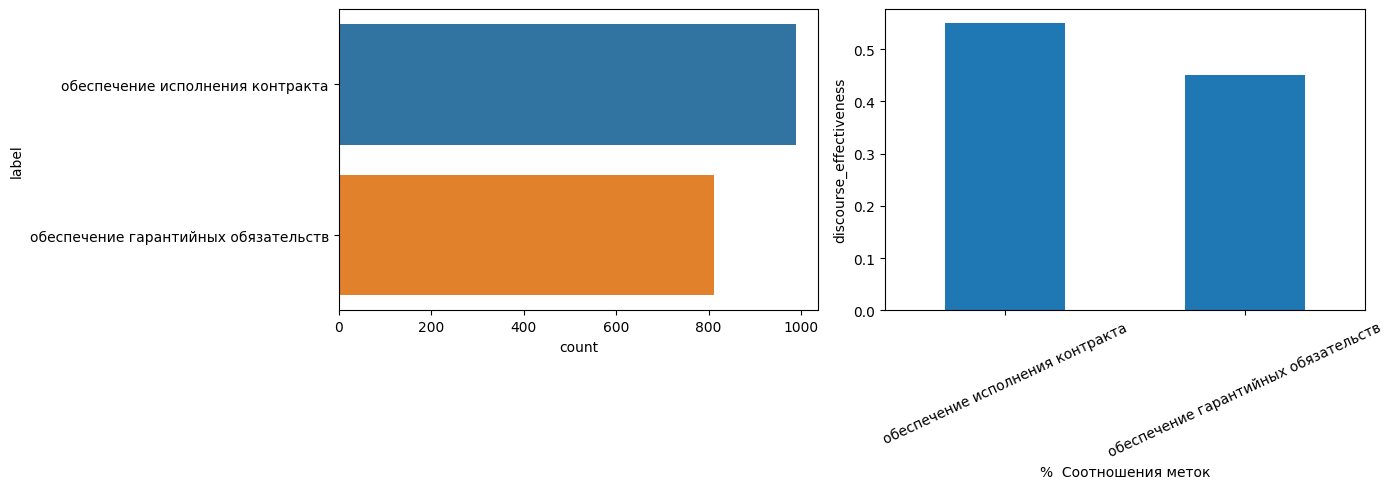

In [12]:
stats_target = train_df['label'].value_counts(normalize=True)
print(stats_target)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train_df,y='label')
plt.subplot(1,2,2)
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

In [13]:
def length_text(text):
    return len(text.split())

train_df['len_text'] = train_df['text'].apply(length_text)

In [14]:
train_df

id  \
0     809436509   
1     854885310   
2       4382157   
3     184555082   
4     211645258   
...         ...   
1794  938335285   
1795  214609521   
1796   94811748   
1797  903507299   
1798  926039184   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0                                                               Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ "Номер расчётного счёта" 00000000000

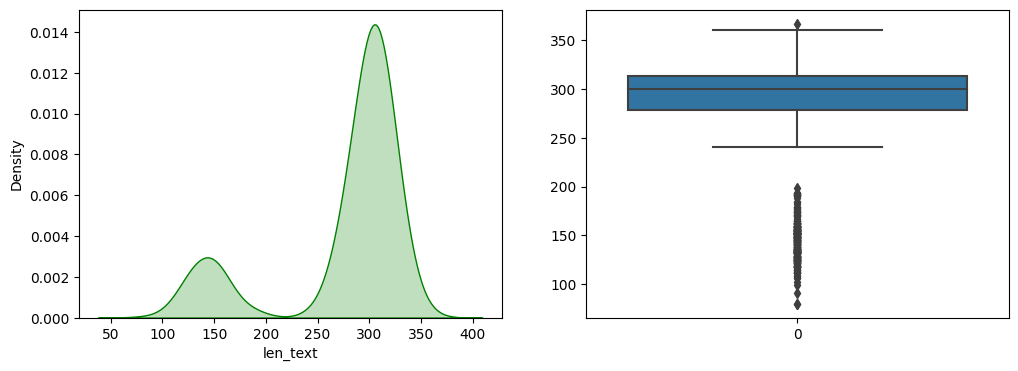

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(train_df['len_text'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(train_df['len_text'])
plt.show()

In [16]:
y_outliers = train_df[abs(zscore(train_df['len_text'])) >= 3 ]
y_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 868 to 1748
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2 non-null      int64 
 1   text            2 non-null      object
 2   label           2 non-null      object
 3   extracted_part  2 non-null      object
 4   len_text        2 non-null      int64 
dtypes: int64(2), object(3)
memory usage: 96.0+ bytes


In [17]:
y_outliers

id  \
868   218092753   
1748  540120178   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
868   1 УТВЕРЖДАЮ Заместитель генерального директора по общим вопросам ООО «Нововоронежская АЭС- Авто» _______________________ С.В. Козлов «____»________________ 2022 ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ открытый одноэтапный запрос предложений в электронной форме без предварительного квалификационного отбора на право заключения договора на Поставку бензина и дизельного топлива на 2022 – 2023 г.г. ТОМ 1 «ОБЩАЯ И КОММЕРЧЕСКАЯ ЧАСТИ» 2022 2 СОДЕРЖАНИЕ Оглавление ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ .....................................................................................................1 СОДЕРЖАНИЕ .......................................................................................................................................2 1. ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАКУПКИ ...............................................................................3 ЧАСТЬ 1 ................................................................................................................................................10 2. ТРЕБОВА ТОМ 2 Техническое задание приведено в виде отдельного файла.   
1748  1 УТВЕРЖДАЮ: Заместитель генерального директора по общим вопросам ООО «Нововоронежская АЭС- Авто» _______________________ С.В. Козлов «____»________________ 2022 ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ открытый запрос предложений в электронной форме на право заключения договора на Поставку продуктов питания: молочная продукция г. Билибино. ТОМ 1 «ОБЩАЯ И КОММЕРЧЕСКАЯ ЧАСТИ» 2022 2 СОДЕРЖАНИЕ Оглавление ЗАКУПОЧНАЯ ДОКУМЕНТАЦИЯ .....................................................................................................1 СОДЕРЖАНИЕ .......................................................................................................................................2 1. ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАКУПКИ ...............................................................................3 ЧАСТЬ 1 ................................................................................................................................................10 2. ТРЕБОВАНИЯ. ДОКУМЕНТЫ. СОСТАВ ЗАЯВКИ НА УЧАСТИЕ В ЗАКУПКЕ. ... ТОМ 2 Техническое задание приведено в виде отдельного файла.   

                                     label  \
868   обеспечение гарантийных обязательств   
1748  обеспечение гарантийных обязательств   

                                              extracted_part  len_text  
868   {'text': [''], 'answer_start': [0], 'answer_end': [0]}        80  
1748  {'text': [''], 'answer_start': [0], 'answer_end': [0]}        80

# Обнаружены выбросы, удалю их из обучающей выборки.

In [18]:
train_df=train_df.query('len_text!=80')

# Обучающий датасет формирование

In [19]:
train_df['text_str'] = train_df.apply(lambda row: ''.join(dict(row['extracted_part'])['text']), axis=1)
train_df['text_start'] = train_df.apply(lambda row: dict(row['extracted_part'])['answer_start'][0], axis=1)
train_df['text_end'] = train_df.apply(lambda row: dict(row['extracted_part'])['answer_end'][0], axis=1)

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1797 entries, 0 to 1798
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1797 non-null   int64 
 1   text            1797 non-null   object
 2   label           1797 non-null   object
 3   extracted_part  1797 non-null   object
 4   len_text        1797 non-null   int64 
 5   text_str        1797 non-null   object
 6   text_start      1797 non-null   int64 
 7   text_end        1797 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 126.4+ KB


In [21]:
train_df

id  \
0     809436509   
1     854885310   
2       4382157   
3     184555082   
4     211645258   
...         ...   
1794  938335285   
1795  214609521   
1796   94811748   
1797  903507299   
1798  926039184   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0                                                               Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ "Номер расчётного счёта" 00000000000

In [22]:
train_df['target']=1

In [23]:
train_df['ent']=''
train_df['pre']=0

# EDA для искомых данных


In [24]:
train_df['len_text_str'] = train_df['text_str'].apply(length_text)

len_text_str
0       0.169727
7       0.149694
15      0.091820
5       0.080134
11      0.058431
13      0.041736
16      0.040623
12      0.037284
10      0.037284
14      0.037284
20      0.035058
8       0.028381
17      0.027268
18      0.021703
19      0.021703
21      0.020033
24      0.016138
22      0.016138
9       0.015582
23      0.011686
6       0.008347
26      0.006121
25      0.005008
31      0.004452
30      0.003895
29      0.003339
27      0.002782
28      0.002782
32      0.001669
4       0.001113
35      0.001113
36      0.000556
40      0.000556
39      0.000556

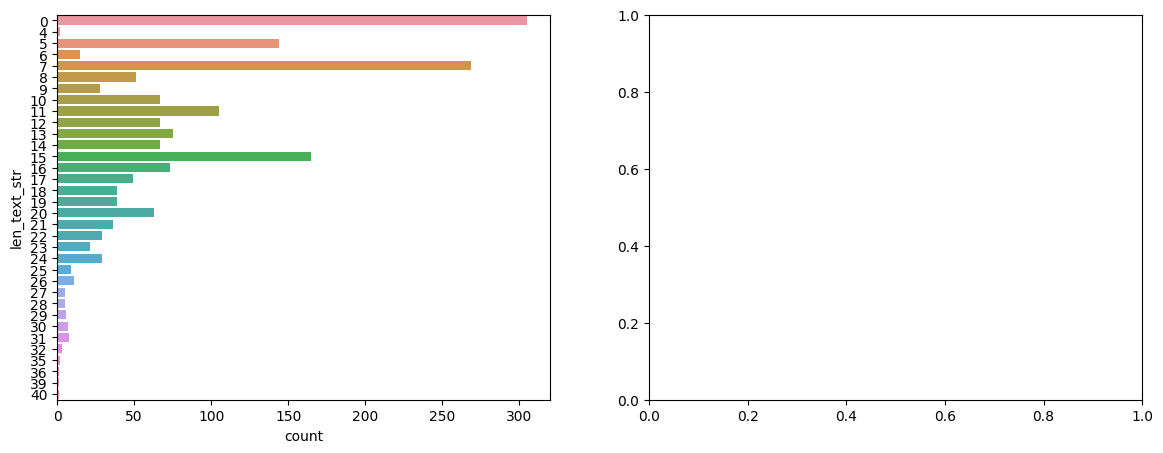

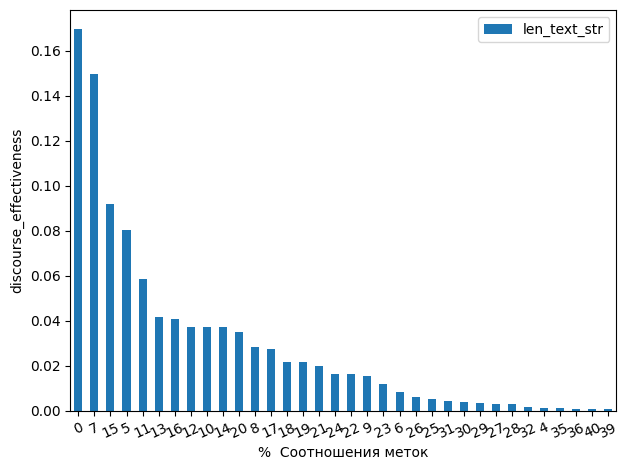

In [25]:
stats_target = train_df['len_text_str'].value_counts(normalize=True)
stats_target=pd.DataFrame(stats_target)
display(stats_target)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train_df,y='len_text_str')
plt.subplot(1,2,2)
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

In [26]:
stats_target.head(10)['len_text_str'].sum()

0.7440178074568726

In [27]:
for i in stats_target.index:
    print('________________Образец строки______________________-')
    print('Количество знаков = ',i, 'процент встречаемости= ',stats_target.loc[[i]].len_text_str*100)
    print(train_df.query('len_text_str==@i').head(1).text_str.values[0])
    print()
    print()
    print()

________________Образец строки______________________-
Колличество знаков =  0 процент встречаемости=  0    16.972732
Name: len_text_str, dtype: float64




________________Образец строки______________________-
Колличество знаков =  7 процент встречаемости=  7    14.969393
Name: len_text_str, dtype: float64
Размер обеспечения исполнения контракта 6593.25 Российский рубль



________________Образец строки______________________-
Колличество знаков =  15 процент встречаемости=  15    9.18197
Name: len_text_str, dtype: float64
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта



________________Образец строки______________________-
Колличество знаков =  5 процент встречаемости=  5    8.013356
Name: len_text_str, dtype: float64
Размер обеспечения исполнения контракта 10.00%



________________Образец строки______________________-
Колличество знаков =  11 процент встречаемости=  11    5.843072
Name: len_text_str, dtype: float64
Об

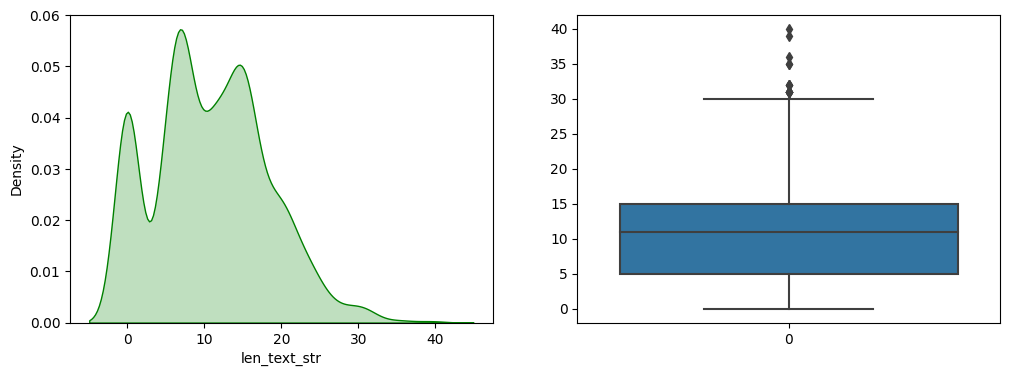

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(train_df['len_text_str'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(train_df['len_text_str'])
plt.show()

In [29]:
y_outliers = train_df[abs(zscore(train_df['len_text_str'])) >= 3 ]
y_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1174 to 1504
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5 non-null      int64 
 1   text            5 non-null      object
 2   label           5 non-null      object
 3   extracted_part  5 non-null      object
 4   len_text        5 non-null      int64 
 5   text_str        5 non-null      object
 6   text_start      5 non-null      int64 
 7   text_end        5 non-null      int64 
 8   target          5 non-null      int64 
 9   ent             5 non-null      object
 10  pre             5 non-null      int64 
 11  len_text_str    5 non-null      int64 
dtypes: int64(7), object(5)
memory usage: 520.0+ bytes


In [30]:
y_outliers

id  \
1174  792867528   
1386  360876826   
1412  513265910   
1473  127269228   
1504  873845087   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               text  \
1174                    Контракт № ________ на поставку эхолота гидрографического для нужд филиала ФГБУ «Балтийско-Арктическая техмордирекция» Калининградский – г. Калининград г. ____________ «__» __________ 202__ года Федеральное государственное бюджетное учреждение «Балтийско-Арктическая дирекция по  обеспечения может быть уменьшен в порядке и случаях, которые предусмотрены частями 7, 7.1, 7.2 и 7.3 статьи 96 Федерального закона № 44-ФЗ. Действие указанного пункта не распространяется на случаи, если Поставщиком предоставлена недостоверная (поддельная) независимая гарантия. 10.6. Срок возврата Заказчиком Поставщику денежных средств, внесенных в качестве обеспечения исполнения Контракта (если такая форма обеспечения исполнения Контракта применяется Поставщиком), в том числе части этих денежных средств в случае уменьшения размера обеспечения исполнения Контракта в соответствии с частями 7, 7.1, 7.2 статьи 96 Федерального закона № 44-ФЗ: не позднее 15 (пятнадцати) дней с даты исполнения Поставщиком обязательств, предусмотренных Контрактом, на счет, указанный Поставщиком. 10.7. В случае неиспо

# Обнаружены выбросы, удалю их из обучающей выборки.

In [31]:
train_df=train_df.query('len_text_str!=35')
train_df=train_df.query('len_text_str!=36')
train_df=train_df.query('len_text_str!=39')
train_df=train_df.query('len_text_str!=40')

# Вывод.
* Данные готовы к исследованию. 
* обнаружены и удалены выбросы в текстах и искомых фрагментах.
* Искомые фрагменты в большинстве случаев однотипны и могут быть описаны регулярными выражениями или паттернами nlp.
* Accuracy не прибегая к машинному обучению может составлять до 0.74, простым написанием 10 регулярных выражений или паттернов nlp.
* Учитывая характер разметки данных, будем использовать spacy.

# Сформируем кросвалидационные выборки.

In [32]:
X = train_df
y = train_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

In [33]:
X_train.shape

(896, 12)

In [34]:
y_train.shape

(896, 12)

In [35]:
X_test.shape

(896, 12)

In [36]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 187 to 1786
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              896 non-null    int64 
 1   text            896 non-null    object
 2   label           896 non-null    object
 3   extracted_part  896 non-null    object
 4   len_text        896 non-null    int64 
 5   text_str        896 non-null    object
 6   text_start      896 non-null    int64 
 7   text_end        896 non-null    int64 
 8   target          896 non-null    int64 
 9   ent             896 non-null    object
 10  pre             896 non-null    int64 
 11  len_text_str    896 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 91.0+ KB


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 0 to 1798
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1792 non-null   int64 
 1   text            1792 non-null   object
 2   label           1792 non-null   object
 3   extracted_part  1792 non-null   object
 4   len_text        1792 non-null   int64 
 5   text_str        1792 non-null   object
 6   text_start      1792 non-null   int64 
 7   text_end        1792 non-null   int64 
 8   target          1792 non-null   int64 
 9   ent             1792 non-null   object
 10  pre             1792 non-null   int64 
 11  len_text_str    1792 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 182.0+ KB


# nlp 

# Сформируем TRAIN_DATA

In [38]:
TRAINING_DATA=[]
for index, row in  train_df.iterrows():
    if row['text_start']:
        TRAINING_DATA.append((row['text'],{"entities":[(row['text_start'],row['text_end'],row['label'])]}))
    else:
        TRAINING_DATA.append((row['text'],{"entities":[]}))

In [39]:
TRAINING_DATA

[('Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч.

In [40]:
#re.finditer(substr, str1)] 
print(train_df['extracted_part'].head(1).astype( str ))

0    {'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'], 'answer_start': [1279], 'answer_end': [1343]}
Name: extracted_part, dtype: object


# Обучим  модель.

In [41]:
nlp = spacy.blank("ru")
ner = nlp.create_pipe("ner")
nlp.add_pipe(ner)
ner.add_label("обеспечение исполнения контракта")
ner.add_label("обеспечение гарантийных обязательств")
nlp.begin_training()
nlp=spacy.load("model4")

for i in range(5,6):
    random.shuffle(TRAINING_DATA)
    for batch in spacy.util.minibatch(TRAINING_DATA):
        texts = [text for text, annotation in batch]
        annotations = [annotation for text, annotation in batch]
        nlp.update(texts, annotations)
    
        #Валидация 
    for index, row in X_train.iterrows():
        doc = nlp(row['text'])
        if doc.ents:
            X_train['ent'].loc[index]=str(doc.ents[0])
        else:
            X_train['ent'].loc[index]=''
        
        
    for index, row in X_train.iterrows():
        if X_train['ent'].loc[index]==X_train['text_str'].loc[index]:
            X_train['pre'].loc[index]=1
        
    print('Эпоха', i, )
    print('accuracy обучающей выборки', accuracy_score(X_train['target'], X_train['pre']))
    print('-----------------------------------------------------------------------------')
        
        
        
        
    for index, row in X_test.iterrows():
        doc = nlp(row['text'])
        if doc.ents:
            X_test['ent'].loc[index]=str(doc.ents[0])
        else:
            X_test['ent'].loc[index]=''
        
        
    for index, row in X_test.iterrows():
        if X_test['ent'].loc[index]==X_test['text_str'].loc[index]:
            X_test['pre'].loc[index]=1
        
    print('Эпоха', i, )
    print('accuracy обучающей 2  выборки', accuracy_score(X_test['target'], X_test['pre']))
    print('-----------------------------------------------------------------------------')
        #Валидация
        
    nlp.to_disk("model"+str(i))

Эпоха 5
accuracy обучающей выборки 0.9553571428571429
-----------------------------------------------------------------------------
Эпоха 5
accuracy вылидационной  выборки 0.9497767857142857
-----------------------------------------------------------------------------


# Вывод:
    Обучение проходило в два этапа, сначала с валидационной выборкой. Переобучения не обнаружено!
    Затем модель доучена на оставшихся данных из валидационной выборки.
    
    Обученная spacy модель умеет находить в тексте именованные сущности 2-х типов: 'обеспечение гарантийных      обязательств', 'обеспечение исполнения контракта'.

In [42]:
nlp=spacy.load("model4")

In [43]:

doc = nlp(
'''УТВЕРЖДЕНО решением Единой закупочной комиссии ООО «Технический заказчик Фонда развития территорий» Извещение о проведении открытого конкурса в электронной форме и документация о проведении открытого конкурса в электронной форме на выполнение ия участникам закупки документации о закупке – с 02.09.2022 по 21.09.2022 13.6 В случае если запрос на предоставление документации о закупке поступил на почтовый адрес, указанный в пункте 2 настоящего извещения, заказчик, организатор закупки предоставляет документацию о закупке по адресу, указанному в пункте 2 настоящего извещения. 13.7 В случае если запрос на предоставление документации о закупке поступил на адрес электронной почты, указанный в пункте 2 настоящего извещения, заказчик, организатор закупки направляет документацию о закупке на адрес электронной почты, указанный в запросе на предоставление документации о закупке. 13.8 Документация о закупке заинтересованному лицу предоставляется бесплатно. 14. Информация о размере обеспечения заявок на участие в закупке 14.1 Обеспечение заявки – не устанавливается 14.2 Информация о порядке и способе обеспечения заявок на участие в закупке указана в п. 4 документации о закупке. 15. Информация о размере обеспечения исполнения договора 15.1 Обеспечение исполнения договора устанавливается в размере 2% - 43 375 595 (сорок три миллиона триста семьдесят пять тысяч пятьсот девяносто пять) рублей, 65 копеек. 15.2 Информация о порядке и способе обеспечения исполнения договора на участие в закупке указана в п. 5 документации о закупке. 15.3 Размер обеспечения гарантийных обязательств установлен в размере 2% (два процента) от цены договора. 15.4 Порядок и способ предоставления обеспечения гарантийных обязательств указан в п.8.4.1. Проекта договора. 16. Антидемпинговые меры 16.1. Под демпингом понимается предложение цены, сделанное участником закупки, на 25 (двадцать пять) процентов и более ниже начальной (максимальной) цены договора (цены единицы услуги) (далее – Предложение с признаками демпинга), за исключением случаев предоставления участником закупки в составе заявки информации о наличии у него опыта поставки товаров, выполнения работ, оказания услуг по предмету закупки на сумму не менее 50 (пятидесяти) процентов от начальной (максимальной) цены договора/предельной цены договора, устан Руководитель/уполномоченный представитель участника закупки или каждого лица, выступающего на стороне коллективного участника закупки ________________ (Фамилия И.О.) (реквизиты документа, подтверждающего полномочия) (подпись)''')

for ent in doc.ents:
    if ent.label_ == "обеспечение исполнения контракта" and ent.start != 0:
        print(ent.text, ent.label_)



Обеспечение исполнения договора устанавливается в размере 2% обеспечение исполнения контракта


In [44]:
ents = [(e.text, e.label_,) for e in doc.ents]
print(ents)  

[('Обеспечение исполнения договора устанавливается в размере 2%', 'обеспечение исполнения контракта')]


In [45]:

displacy.render(doc, style='ent', jupyter=True)

In [46]:
nlp.get_pipe("ner").labels

('обеспечение гарантийных обязательств', 'обеспечение исполнения контракта')

# Валидация на всей обучающей выборке

In [47]:
for index, row in train_df.iterrows():
    string=''
    doc = nlp(row['text'])
    if doc.ents:
        for i in doc.ents:
            if i.label_==row['label']:
                string=i.text
        print(string)
        #test_df['ent'].loc[index]=str(doc.ents[0])
        train_df['ent'].loc[index]=string
    else:
        train_df['ent'].loc[index]=''
    

Размер обеспечения исполнения контракта 6593.25 Российский рубль
Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта.
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта устанавливается в размере 5 (пять) процентов от цены, по которой заключается контракт и составляет ______
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) ц

Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 9523.60 Российский рубль
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 15.00%
Обеспечение гарантийных обязательств устанавливается в размере 5% процентов начальной (максимальной) цены контракта, что составляет 60 787
Размер обеспечения исполнения контракта 3354.78 Российский рубль
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 1383.33 Российский рубль
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения гарантийных обязательств 11599.38 Российский рубль
таким участником обеспечения исполнения контракта в размере, превышающем в 1,5 раза размер обеспечения исполнения контракта, указанный в извещении, но не менее чем 10 процентов от начальной (максимальной) цены контракта
Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта 

Размер обеспечения исполнения контракта 1635.00 Российский рубль
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения контракта 54517.53 Российский рубль
Размер обеспечения исполнения контракта 17389.85 Российский рубль
Размер обеспечения исполнения контракта 120711.45 Российский рубль
Размер обеспечения исполнения контракта 0.50%
Размер обеспечения исполнения контракта 10.00%
Размер обеспечения исполнения государственного контракта составляет 30 % от начальной (максимальной) цены контракта
Размер обеспечения исполнения контракта 10.00%
размер обеспечения исполнения контракта - 5 (пяти) процентов цены контракта.
Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 10 % от начальной (максимальной) цены контракта
Размер обеспечения исполнения Контракта составляет ______________рублей, что составляет 5 процентов от начальной (максимальной) цены Контракта.
Размер обеспечения исполнения контракта 8536320.00 Росси

Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 5 % от цены
Размер обеспечения исполнения контракта 10.00%
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Размер обеспечение исполнения контракта устанавливается от 0,5 %

Поставщик внес обеспечение исполнения Контракта в размере __ , что составляет 5 % Цены Контракта в форме безотзывной независимой гарантии
Поставщик внес обеспечение исполнения Контракта в размере __ , что составляет 5 % Цены Контракта в форме безотзывной независимой гарантии
Поставщик внес обеспечение исполнения Контракта в размере __ , что составляет 5 % Цены Контракта в форме безотзывной независимой гарантии
Поставщик внес обеспечение исполнения Контракта в размере __ , что составляет 5 % Цены Контракта в форме безотзывной независимой гарантии
Размер обеспечения исполнения контракта - 5% от цены контракта (без НДС).
Размер обеспечения исполнения контракта 4030.00 Российский рубль
Размер обеспечения исполнения контракта составляет 5,00% от начальной цены контракта, что составляет 42 500,00
Размер обеспечения исполнения контракта 20491.05 Российский рубль
Размер обеспечения исполнения контракта 5.00%
Обеспечение исполнения настоящего Контракта устанавливается в размере 1 (одного) проце

Размер обеспечения исполнения контракта 30.00%
Размер обеспечения исполнения контракта 5 % от цены заключаемого контракта
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения Контракта составляет 10% (десять процентов) от цены Контракта, что составляет ____ (__________)
Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 10 % начальной (максимальной) цены государственного контракта
Размер обеспечения исполнения контракта 1258.65 Российский рубль
Поставщик внес обеспечение исполнения Контракта в размере __ , что составляет 5 % Цены Контракта в форме безотзывной независимой гарантии
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 5.00%
Размер обеспечения исполнения контракта 33809.93 Российский рубль
Размер обеспечения исполнения контракта 5.00%
Подрядчик представляет Заказчику обеспечение исполнения Контракта в виде _______________ в размере 10% от ______________, что сос

Размер обеспечения исполнения договора составляет 5 (пять) процентов от начальной (максимальной) цены договора
Размер обеспечения исполнения договора составляет 5% начальной (максимальной) цены договора
обеспечения исполнения договора в размере, превышающем в полтора раза размер обеспечения исполнения договора, указанный в документации о закупке, но не менее, чем 10 (десять) процентов от начальной (максимальной) цены договора; б) обеспечения исполнения договора в размере, установленном в документации о закупке, а также информации, подтверждающей добросовестность такого участника на дату подачи заявки в соответствии с пунктом 2 настоящего раздела Положения о закупке, и обоснования предлагаемой цены договора, которое может включать в себя гарантийное письмо от производителя с указанием цены и количества поставляемого товара, документы, подтверждающие наличие товара у участника закупки, иные документы и расчеты, подтверждающие возможность участника закупки осуществить поставку товара, вып

Обеспечение исполнения договора установлено в размере 5% от начальной максимальной цены договора
Поставщик предоставляет обеспечение исполнения договора в размере 2 (два) % от начальной (максимальной) цены договора
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не более 5% (пяти) от начальной (максимальной) цены договора
Размер обеспечения исполнения договора: 5 % начальной максимальной цены договора (цены лота)
Размер обеспечения исполнения гарантийных обязательств не может превышать 2 % начальной (максимальной) цены договора (цены лота).
размер обеспечения исполнения договора 10% от начальной максимальной цены договора
обеспечения исполнения договора в размере, превышающем в полтора раза размер обеспечения исполнения договора, указанный в документации о закупке, но не менее, чем 10 (десять) процентов от начальной (максимальной) цены договора; б) обеспечения исполнения договора в размере, установленном в документац

к такому участнику применяется требование об обеспечении исполнения договора в размере 30% (тридцати процентов) от начальной (максимальной) цены договора без учета НДС
к такому участнику применяется требование об обеспечении исполнения договора в размере 30% (тридцати процентов) от начальной (максимальной) цены договора без учета НДС
Установить обеспечение исполнения Договора в размере 5% (пять) процентов от начальной (максимальной) цены Договора
Обеспечение исполнения договора в размере не менее 5% от цены договора
Размер обеспечения исполнения договора, руб. 32 550,00
Поставщик до заключения Договора предоставляет Заказчику обеспечение исполнения Договора в размере 5% Начальной максимальной цены Договора
такой участник обязан предоставить обеспечение исполнения договора в размере 5 процентов от начальной (максимальной) цены договора (цены лота)
Размер обеспечения исполнения Договора устанавливается в размере 5% от НМЦД
Обеспечение исполнения Договора составляет 5 % от начальной (макс

Обеспечение исполнения Договора устанавливается в размере 5 процент(ов,а) начальной (максимальной) цены договора.
требование об обеспечении исполнения договора в пределах от 5 до 30 процентов начальной (максимальной) цены договора
Если в документации о закупке, установлено требование к обеспечению исполнения договора, размер такого обеспечения: а) не может превышать 5 процентов начальной (максимальной) цены договора (цены лота)
Размер обеспечения исполнения договора составляет 5% (пять процентов) начальной максимальной цены договора
Поставщик предоставляет обеспечение исполнения Договора в размере 5 % от начальной максимальной цены Договора на сумму 7 447
Сумма обеспечения исполнения договора предусмотрена в следующем размере: 5 (Пяти) % от начальной (максимальной) цены договора
обеспечение исполнения договора в размере не менее 5% от цены договора.
такое лицо предоставляет обеспечение исполнения договора в размере 7,5 % от НМЦ.
такое лицо предоставляет обеспечение исполнения договора 

победителем закупки должно быть представлено обеспечение исполнения договора в размере 5% от предельной цены, указанной в п. 7.1. Извещения
Поставщик при заключении договора должен предоставить Заказчику обеспечение исполнения договора в размере от 0,5 до 5% начальной (максимальной) цены договора.
Размер обеспечения исполнения договора составляет 5 % от начальной (максимальной) цены договора
Размер обеспечения договора 5 % от НМЦД составляет: 23 288 руб. 00 коп.
Размер обеспечения исполнения Договора установлен в размере 5 % от начальной (максимальной) цены Договора.
В документации о закупке может быть установлено требование к обеспечению исполнения договора в размере не более 5 (пяти) процентов от начальной (максимальной) цены договора
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от НМЦ
Обеспечение исполнения договора: Лот 1: 1 107 000,00 рублей Лот 2: 1 673 280,00 рублей Лот 3: 286 506,00 рубл

При этом договор заключается только после предоставления участником такого обеспечения исполнения договора в размере, не превышающем 30 процентов начальной (максимальной) цены договора (цены лота)
Размер обеспечения исполнения Договора составляет 5 % начальной (максимальной) цены договора в сумме ______________________________________________________
Обеспечение исполнения гарантийных обязательств устанавливается в размере 5 % начальной (максимальной) цены договора в сумме ___________________________________________________
Обеспечение гарантийных обязательств по Договору Устанавливается 5% от начальной максимальной цены договора- 27 400,00 (Двадцать семь тысяч четыреста) рублей 00 копеек
Размер обеспечения исполнения договора: 5% от начальной (максимальной) цены договора
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от НМЦ
Размер обеспечения исполнения договора 3% начальной (максимальной) цены д

на протяжении указанного в Контракте гарантийного срока, устанавливается обеспечение гарантийных обязательств в размере 1% (одного процента) начальной (максимальной) цены Контракта, что составляет 23 000 (двадцать три тысячи) рублей
Размер обеспечения гарантийных обязательств 946800.00 Российский рубль
Размер обеспечения гарантийных обязательств 946800.00 Российский рубль
Размер обеспечения гарантийных обязательств 946800.00 Российский рубль
Размер обеспечения гарантийных обязательств 54182.46 Российский рубль
Размер обеспечения гарантийных обязательств 54182.46 Российский рубль
Размер обеспечения гарантийных обязательств 54182.46 Российский рубль
Размер обеспечения гарантийных обязательств 460.00 Российский рубль
Размер обеспечения гарантийных обязательств: 0,00 рублей. Доля: 0,00 % от начальной (максимальной) цены контракта 37 Требования к предоставлению гарантии производителя и к сроку действия такой гарантии Не предусмотрено 38 Размер обеспечения исполнения контракта[footnoteRef:3]

Размер обеспечения гарантийных обязательств 17986.24 Российский рубль
Обеспечение гарантийных обязательств установлено в размере 5 % от начальной (максимальной) цены Контракта, что составляет 1 222
Размер обеспечения гарантийных обязательств – 3 % начальной (максимальной) цены контракта – 17460,50 руб. (
Размер обеспечения гарантийных обязательств 169291.20 Российский рубль
Размер обеспечения исполнения контракта, гарантийных обязательств 5% от НМЦК в сумме – 683 (шестьсот восемьдесят три) рубля 33 копейки.
Размер обеспечения гарантийных обязательств 5% от начальной (максимальной) цены контракта – 15263 (пятнадцать тысяч двести шестьдесят три) рубля
Размер обеспечения исполнения гарантийных обязательств составляет 0,01 % от начальной (максимальной) цены контракта и предоставляется до момента оформления документа
Размер обеспечения гарантийных обязательств 11860.25 Российский рубль
Размер обеспечения гарантийных обязательств - 1% от начальной цены контракта, что составляет 30 433,00 руб

Размер обеспечения гарантийных обязательств составляет 34 438,38 (Тридцать четыре тысячи четыреста тридцать восемь) рублей 38 копеек (1 % от начальной (максимальной) цены контракта).
Обеспечение гарантийных обязательств устанавливается в размере 2 % от начальной (максимальной) цены контракта, что составляет 19 994,00 рублей.
Размер обеспечения гарантийных обязательств 43750.00 Российский рубль
Размер обеспечения гарантийных обязательств 27950.00 Российский рубль
Размер обеспечения гарантийных обязательств составляет _______ рублей ____ копеек (1% от начальной (максимальной) цены Контракта).
Размер обеспечения гарантийных обязательств составляет _______ рублей ____ копеек (1% от начальной (максимальной) цены Контракта).
Обеспечение гарантийных обязательств устанавливается в размере 1 (одного) процента от начальной (максимальной) цены Контракта.
Размер обеспечения гарантийных обязательств - 1 % начальной максимальной цены Договора, что составляет ________ (_____________) рублей _______ к

Размер обеспечения гарантийных обязательств 1% (102,00 руб.)
должен предоставить Государственному заказчику обеспечение гарантийных обязательств в размере 5% начальной (максимальной) цены Контракта, что составляет 83 765,00руб.
Размер обеспечения гарантийных обязательств 334.97 Российский рубль
Размер обеспечения гарантийных обязательств 4235398.64 Российский рубль
Размер обеспечения гарантийных обязательств 192289.70 Российский рубль
Размер обеспечения гарантийных обязательств: 0,00 рублей. Доля: 0,00 % от начальной (максимальной) цены контракта 37 Требования к предоставлению гарантии производителя и к сроку действия такой гарантии Не установлены 38 Размер обеспечения исполнения контракта[footnoteRef:3] [3: В случае заключения контракта по результатам определения поставщиков (подрядчиков, исполнителей) в соответствии с пунктом 1 части 1 статьи 30 Федерального закона № 44-ФЗ размер обеспечения исполнения контракта, в том числе предоставляемого с учетом положений статьи 37 Федерального 

Размер обеспечения гарантийных обязательств 178409.22 Российский рубль
Размер обеспечения гарантийных обязательств: 5% от начальной (максимальной) цены контракта (максимального значения цены контракта)
Размер обеспечения гарантийных обязательств составляет 1 процент начальной (максимальной) цены контракта, что составляет ____________ рублей ___ копеек.
Размер обеспечения гарантийных обязательств 13642.50 Российский рубль
Обеспечение гарантийных обязательств предоставляется в размере _____ , что составляет 0.5 % начальной (максимальной) цены контракта, предусмотренной извещением об осуществлении закупки.
Размер обеспечения гарантийных обязательств 1663.67 Российский рубль
Обеспечение гарантийных обязательств устанавливается в размере 6 159,00 рублей. Гарантийное обязательство представляется на срок не менее 12 месяцев.
Размер обеспечения исполнения гарантийных обязательств 1 % начальной (максимальной) цены контракта
если требование обеспечения исполнения контракта, гарантийных обязатель

Обеспечение гарантийных обязательств устанавливается в размере 0% от начальной (максимальной) цены контракта и составляет 0 (ноль) рублей 00 копеек.
Размер обеспечения гарантийных обязательств 71387.04 Российский рубль
Обеспечение гарантийных обязательств устанавливается в размере 0,5 % от начальной максимальной цены контракта, что составляет 5 506 руб. 35 коп.
Размер обеспечения гарантийных обязательств 36990.74 Российский рубль
Обеспечение Поставщиком гарантийных обязательств устанавливается в размере 3 % начальной максимальной цены контракта что составляет ___ (________) рублей __ копеек.
Размер обеспечения гарантийных обязательств составляет 1 % начальной (максимальной) цены контракта.
Размер обеспечения гарантийных обязательств составляет: 3,00 % от начальной (максимальной) цены контракта, что составляет 216 904,38 рублей.
Размер обеспечения гарантийных обязательств 418836.95 Российский рубль
Обеспечение гарантийных обязательств устанавливается в размере 5 % от начальной (максимал

Обеспечение возврата аванса и/или гарантийных обязательств: Установлено.
Размер обеспечения гарантийных обязательств по договору в электронной форме 1 (один) процент от начальной (максимальной) цены договора, что составляет 325 532
Обеспечение исполнения гарантийных обязательств по настоящему Договору представляется на сумму не менее 5% от стоимости всех выполненных работ.
Обеспечение исполнения гарантийных обязательств по договору устанавливается в размере 2% начальной (максимальной) цены договора и составляет 58 942,70 рубля.
согласно п. 3.1. Договора Поставщик представляет Заказчику обеспечение гарантийных обязательств на поставленные товары. Размер обеспечения гарантийных обязательств: 1% от начальной (максимальной) цены контракта (договора), что составляет 125 350,10 рублей
Обеспечение исполнения договора, гарантийных обязательств.
Обеспечение исполнения гарантийных обязательств устанавливается в размере 5 % от НМЦК
Установлен Размер обеспечения гарантийных обязательств: 10 % от н

Поставщик может предоставить Покупателю в качестве обеспечения исполнения гарантийных обязательств безусловную и безотзывную банковскую гарантию на сумму равную не менее 5% (пять процентов) от стоимости работ.
Размер обеспечения исполнения гарантийных обязательств составляет: _________0__________ рублей, НДС не облагается. Срок предоставления обеспечения исполнения гарантийных обязательств: __________________________________________ Минимальный срок гарантийных обязательств: ___________________________________________ Порядок предоставления обеспечения исполнения гарантийных обязательств: в соответствии с частью IX «ПРОЕКТ ДОГОВОРА» извещении 25. Реквизиты счета для перечисления денежных средств в качестве исполнения договора, гарантийных обязательств, реквизиты для оформления независимой гарантии в качестве обеспечения заявки, исполнения договора Указать реквизиты для перечислений 26. Возможность Заказчика изменить условия договора по результатам преддоговорных переговоров Предусмотре

In [48]:
for index, row in train_df.iterrows():
        if train_df['ent'].loc[index]==train_df['text_str'].loc[index]:
            train_df['pre'].loc[index]=1
            
    
    

In [49]:

accuracy_score(train_df['target'], train_df['pre'])

0.9592633928571429

In [50]:
train_df.query('pre==0')[['text_str','ent']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 5 to 1773
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_str  73 non-null     object
 1   ent       73 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


# Генерация ответа

In [51]:
test_df = pd.read_json('dataset/test.json', orient='records')
test_df['ent']=''
test_df['answer_start']=0
test_df['answer_end']=0

In [52]:
test_df

id  \
0    762883279   
1    311837655   
2    540954893   
3    274660397   
4    732742591   
..         ...   
313  854936033   
314  576390745   
315  323745820   
316  712286194   
317  880582082   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0    МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд

# В генерации ответа учтем, что в одном текстовом фрагменте могут находиться 2 entity!

In [53]:
for index, row in test_df.iterrows():
    result=-1
    doc = nlp(row['text'])
    string=''
    if doc.ents:
        for i in doc.ents:
            if i.label_==row['label']:
                string=i.text
                result = test_df['text'].loc[index].rfind(string)
                
        print(row['label'])
        print(index)
        print(string)
        #test_df['ent'].loc[index]=str(doc.ents[0])
        test_df['ent'].loc[index]=string
        if result!=-1:
            print(result)
            test_df['answer_start'].loc[index]=result
            test_df['answer_end'].loc[index]=result+len(string)
        
        
    else:
        test_df['ent'].loc[index]=''

обеспечение исполнения контракта
0
Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).
1283
обеспечение исполнения контракта
1
Размер обеспечения исполнения контракта 10.00%
1291
обеспечение исполнения контракта
2
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1300
обеспечение исполнения контракта
3
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1312
обеспечение исполнения контракта
4
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1314
обеспечение исполнения контракта
5
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1304
обеспечение исполнения контракта
6
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
13

обеспечение исполнения контракта
65

обеспечение исполнения контракта
66
Обеспечение исполнения настоящего Контракта устанавливается в размере 5 (пяти) процентов от цены Контракта и составляет _____________
1222
обеспечение исполнения контракта
67
Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 10 % (__________ рублей) от цены, по которой в соответствии с
1318
обеспечение исполнения контракта
68
Размер обеспечения исполнения контракта 786.45 Российский рубль
1282
обеспечение исполнения контракта
69
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
1241
обеспечение исполнения контракта
70
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
1273
обеспечение исполнения контракта
71
Обеспечение исполнения настоящего Контракта установлено в размере 5%.
1272
обеспечение исполнения контракта
72
Обеспечение исполнения настоящего Контракта установлено в ра

обеспечение исполнения контракта
135
Обеспечение исполнения договора составляет: 5 % начальной (максимальной) цены договора, НДС не облагается.
1161
обеспечение исполнения контракта
136
Обеспечение исполнения Договора предоставлено в размере 5% от начальной (максимальной) цены договора на сумму ___
1106
обеспечение исполнения контракта
137
Размер обеспечения исполнения договора составляет 5 процентов начальной (максимальной) цены договора
1245
обеспечение исполнения контракта
138
Сумма обеспечения исполнения договора предусмотрена в следующем размере: 5 % от начальной (максимальной) цены договора
1227
обеспечение исполнения контракта
139
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от НМЦ
1214
обеспечение исполнения контракта
142
не предусмотрено увеличенное от первоначально установленного обеспечения исполнения договора в 1,5 (полтора) раза, но не менее 5% (пяти) от НМЦ
1144
обеспечение исполне

обеспечение гарантийных обязательств
206
Обеспечение гарантийных обязательств установлено в размере 1 % начальной (максимальной) цены контракта, что составляет: 266 577,10 руб
1297
обеспечение гарантийных обязательств
207
Размер обеспечения гарантийных обязательств 23425.80 Российский рубль
1300
обеспечение гарантийных обязательств
208
Размер обеспечения гарантийных обязательств составляет: 0,00 % от начальной (максимальной) цены контракта, что составляет 0,00 рублей.
1299
обеспечение гарантийных обязательств
209
Размер обеспечения гарантийных обязательств 351248.04 Российский рубль
1255
обеспечение гарантийных обязательств
210

обеспечение гарантийных обязательств
211
Размер обеспечения гарантийных обязательств 369900.00 Российский рубль
1309
обеспечение гарантийных обязательств
212
Поставщик предоставляет обеспечение гарантийных обязательств в размере 10% от начальной (максимальной) цены контракта в случае установления требований к таким обязательствам в соответствии с ч.4 ст.33, ст.

обеспечение гарантийных обязательств
258
Размер обеспечения гарантийных обязательств 242500.00 Российский рубль
1270
обеспечение гарантийных обязательств
259
Обеспечение исполнения гарантийных обязательств по настоящему Договору представляется на сумму не менее 5% от стоимости всех выполненных работ.
1249
обеспечение гарантийных обязательств
260

обеспечение гарантийных обязательств
261

обеспечение гарантийных обязательств
264
согласно п. 3.1. Договора Поставщик представляет Заказчику обеспечение гарантийных обязательств на поставленные товары. Размер обеспечения гарантийных обязательств: 1% от начальной (максимальной) цены контракта (договора), что составляет 15 474,91 рублей (пятнадцать тысяч четыреста семьдесят четыре рубля 91 копейка).
1342
обеспечение гарантийных обязательств
268

обеспечение гарантийных обязательств
270
Заказчиком установлено требование обеспечения исполнения договора и (или) обеспечения исполнения гарантийных обязательств 10 % от начальной (максимальной) цены д

In [54]:
test_df.head(318)

id  \
0    762883279   
1    311837655   
2    540954893   
3    274660397   
4    732742591   
..         ...   
313  854936033   
314  576390745   
315  323745820   
316  712286194   
317  880582082   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0    МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд

In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            318 non-null    int64 
 1   text          318 non-null    object
 2   label         318 non-null    object
 3   ent           318 non-null    object
 4   answer_start  318 non-null    int64 
 5   answer_end    318 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 15.0+ KB


In [56]:
test_df.query('answer_start==0')[['text','ent']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 19 to 317
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    88 non-null     object
 1   ent     88 non-null     object
dtypes: object(2)
memory usage: 2.1+ KB


In [57]:
test_df.query('answer_start==0')[['text','label','ent']]

text  \
19                                                                                                                                                                                    30 Приложение УТВЕРЖДЕНО приказом Кировского областного территориального фонда обязательного медицинского страхования от 05.09.2022 № 753 Извещение об осуществлении закупки на поставку радиоэлектронной продукции и расходных материалов (бесконтактных считывателей прокси-карт) № го союза. Подтверждением страны происхождения товаров является указание (декларирование) участником закупки наименования страны происхождения товара. 17.2.1 Контракт заключается по цене: 17.2.1.1. Сниженной на 15 процентов от предложенной победителем аукциона, если заявка такого победителя содержит предложение о поставке товаров, страной происхождения хотя бы одного из которых является иностранной государство (за исключением государств — членов Евразийского экономического союза, Донецкой Народной Республики, Луганской Народной Республики). 17.2.1.2. Предложенной победителем аукциона в случае, если заявка такого победителя содержит предложение о поставке товаров, происходящих исключительно из государств — членов Евразийского экономического союза, из Донецкой Народной Республики, Луганской Народной Республики 18 Размер и порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, условия независимой гарантии, реквизиты счета Обеспечение заявки не установлено 19 Размер обеспечения исполнения контракта 20% от начальной (максимальной) цены контракта – 5054 (пять тысяч пятьдесят четыре) рубля 66 копеек Денежные средства в качестве обеспечения исполнения контракта перечисляются по реквизитам, указанным в пункте 28 настоящего извещения об осуществлении закупки 20 Размер обеспечения гарантийных обязательств 1% от начальной (максимальной) цены контракта – 252 (двести пятьдесят два) рубля 73 копейки Денежные средства в качестве обеспечения гарантийных обязательств перечисляются по реквизитам, указанным в пункте 28 настоящего извещения об осуществлении закупки 21 Порядок предоставления обеспечения исполнения контракта, гарантийных обязательств, требования к обеспечению 21.1.1. Исполнение контракта, гарантийные обязательства обеспечиваются участником закупки предоставлением независимой гарантии, соответствующей требованиям статьи 45 Закона, или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обесп Начальник отдела системного администрирования и технического обеспечения управления информационного обеспечения ___________ В.А. Одинцов   
65   Приложение 1 к приказу Администрации Губернатора и Правительства Орловской области от ________________ 2022 г. № ______ ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЭЛЕКТРОННОГО АУКЦИОНА на определение исполнителя для осуществления закупки услуг для обеспечения занием предмета запроса, но без указания УЗ, от которого поступил указанный запрос, при условии, что указанный запрос поступил заказчику не позднее чем за три дня до окончания срока подачи заявок на участие в аукционе. Дата начала предоставления УЗ разъяснений положений извещения: 08 сентября 2022 г. Дата окончания срока предоставления УЗ разъяснений положений извещения: 14 сентября 2022 г. 1.16 Дата и время окончания срока подачи заявок на участие в аукционе 16 сентября 2022 г. 09 часов 00 минут по московскому времени. 1.17 Дата проведения процедуры подачи предложений о цене контракта 16 сентября 2022 г. 1.18 Дата подведения итогов определения исполнителя 19 сентября 2022 г. 1.19 Порядок проведения аукциона Порядок проведения аукциона в соответствии со ст. 49 Федерального закона № 44-ФЗ 1.20 Размер обеспечения исполнения контракта, гарантийных обязательств, срок и порядок их предоставления, требования к обеспечению исполнения контракта, гарантийных обязательств. Антидемпинговые меры. Размер обеспечения исполнения контракта устанавливается в ра

In [58]:
predictions=[]
for index, row in test_df.iterrows():
    predictions.append({
    "id": row['id'],
    "text":row['text'],
    "label": row['label'],
    "extracted_part": {
      "text": [
        row['ent']
      ],
      "answer_start": [
        row['answer_start']
      ],
      "answer_end": [
        row['answer_end']
      ]
    }
  })
    

In [59]:
predictions[0]

{'id': 762883279,
 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Фед

In [60]:
i={
    "id": 809436509,
    "text": "Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 1 ст. 42 Закона № 44-ФЗ \"Номер расчётного счёта\" 00000000000000000000 \"Номер лицевого счёта\" См. прилагаемые документы \"БИК\" 000000000 \"Наименование кредитной организации\" \"Номер корреспондентского счета\" Обеспечение исполнения контракта Требуется обеспечение исполнения контракта Размер обеспечения исполнения контракта 6593.25 Российский рубль Порядок обеспечения исполнения контракта, требования к обеспечению Исполнение контракта, гарантийные обязательства могут обеспечиваться предоставлением независимой гарантии, соответствующей требованиям ст. 45 Федерального закона № 44-ФЗ, или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, гарантийных обязательств, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона № 44-ФЗ участником закупки, с которым заключается контракт, самостоятельно. При этом срок действия независимой гарантии должен превышать предусмотренный контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со ст. 95 Федерального закона № 44-ФЗ. Порядок предоставления и требования о Информация и документы, подтверждающие соответствие участников закупки дополнительным требованиям: 1) исполненный договор; 2) акт приемки оказанных услуг и (или) поставленных товаров, подтверждающий цену оказанных услуг и (или) поставленных товаров 4",
    "label": "обеспечение исполнения контракта",
    "extracted_part": {
      "text": [
        "Размер обеспечения исполнения контракта 6593.25 Российский рубль"
      ],
      "answer_start": [
        1279
      ],
      "answer_end": [
        1343
      ]
    }
  },

In [61]:
i[0]

{'id': 809436509,
 'text': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета

In [62]:
import json
with open('predictions.json', 'w', encoding='utf-8') as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)

## Проверка типов данных в ответе!

In [63]:
def check_valid_JSOn(filename):
    try:
        with open(filename) as file:
         parse_json = json.load(file)
         #print(parse_json) 
         return True
    except ValueError as e:        
        return False
 
print('Валидность :',check_valid_JSOn('dataset/train.json'))
print('валидность :',check_valid_JSOn('predictions.json'))


Валидность : True
валидность : True


In [64]:
f = open('dataset/train.json')
data_train = json.load(f)
f.close()
print(data_train[0])  # or `print data['two']` in Python 2

{'id': 809436509, 'text': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета 

In [65]:
print(type(data_train[0]['id']))
print(type(data_train[0]['text']))
print(type(data_train[0]['label']))
print(type(data_train[0]['extracted_part']['text']))
print(type(data_train[0]['extracted_part']['answer_start']))
print(type(data_train[0]['extracted_part']['answer_end']))
print(type(data_train[0]['extracted_part']['text'][0]))
print(type(data_train[0]['extracted_part']['answer_start'][0]))
print(type(data_train[0]['extracted_part']['answer_end'][0]))

<class 'int'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'str'>
<class 'int'>
<class 'int'>


In [66]:
f = open('predictions.json')
data_test = json.load(f)
f.close()
print(data_test[0]) 

{'id': 762883279, 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Феде

In [67]:
print(type(data_test[0]['id']))
print(type(data_test[0]['text']))
print(type(data_test[0]['label']))
print(type(data_test[0]['extracted_part']['text']))
print(type(data_test[0]['extracted_part']['answer_start']))
print(type(data_test[0]['extracted_part']['answer_end']))
print(type(data_test[0]['extracted_part']['text'][0]))
print(type(data_test[0]['extracted_part']['answer_start'][0]))
print(type(data_test[0]['extracted_part']['answer_end'][0]))

<class 'int'>
<class 'str'>
<class 'str'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'str'>
<class 'int'>
<class 'int'>


### Вывод json валиден, типы данных совпадают

# EDA реузультатов прогнозирования

len_text_str
0        0.276730
7        0.166667
15       0.100629
5        0.078616
13       0.044025
11       0.037736
20       0.034591
12       0.031447
14       0.025157
18       0.025157
8        0.022013
23       0.022013
16       0.018868
10       0.015723
21       0.012579
24       0.009434
9        0.009434
17       0.009434
22       0.006289
48       0.006289
26       0.006289
19       0.006289
32       0.006289
25       0.003145
116      0.003145
37       0.003145
139      0.003145
162      0.003145
34       0.003145
60       0.003145
29       0.003145
38       0.003145

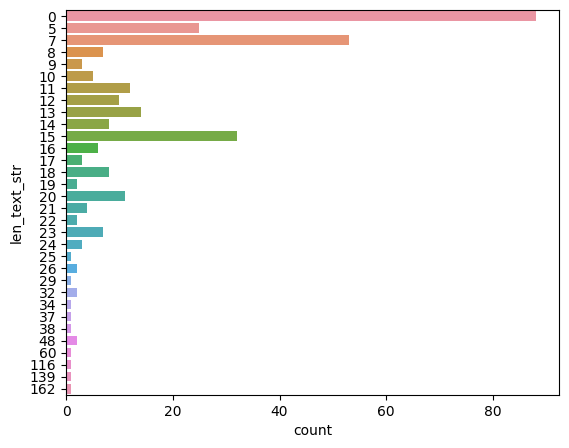

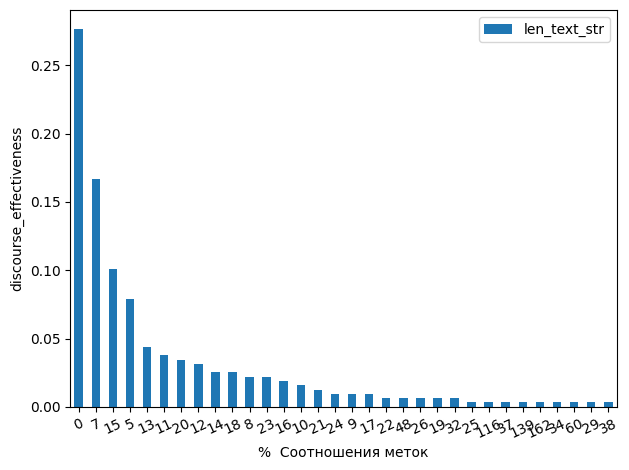

In [68]:
test_df['len_text_str'] = test_df['ent'].apply(length_text)
stats_target = test_df['len_text_str'].value_counts(normalize=True)
stats_target=pd.DataFrame(stats_target)
display(stats_target)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=test_df,y='len_text_str')
stats_target.plot.bar(rot=25)
plt.ylabel('discourse_effectiveness')
plt.xlabel('%  Соотношения меток')
plt.tight_layout()
plt.show()

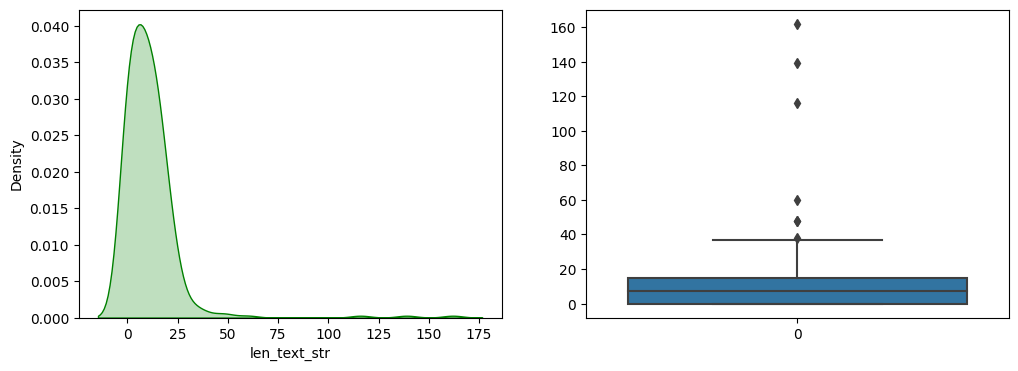

In [69]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(test_df['len_text_str'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(test_df['len_text_str'])
plt.show()

In [70]:
for index, row in test_df.iterrows():
    print(index)
    doc = nlp(row['text'])
    displacy.render(doc, style='ent', jupyter=True)

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


## Сделано:
   
   * Данные загружены, предобработаны, произведено EDA.
   * обнаружены и удалены выбросы в текстах и искомых фрагментах.
   * Искомые фрагменты в большинстве случаев однотипны и могут быть описаны регулярными выражениями или паттернами nlp.
   * Accuracy не прибегая к машинному обучению может составлять до 0.74, простым написанием 10 регулярных выражений или паттернов nlp.
   * Учитывая характер разметки данных, будем использовать spacy.
   
## Обучение

   * Обучение модели проходило на представленных в train данных в два этапа, сначала с валидационной выборкой. Переобучения не обнаружено! Затем модель доучена на оставшихся данных из валидационной выборки.

   * Обученная spacy модель умеет находить в тексте именованные сущности 2-х типов: 'обеспечение гарантийных      обязательств', 'обеспечение исполнения контракта'.
   
   

## Вывод: 
   * В целом модель отрабатывает и находит сущности.
   * Точность на обучающей выборке до 96%.
   * Тестовую по правилам в обучении не задействовали.
   * В наших ответах на 10% больше нулевых результатов, чем в обучающей выборке. Причем при визульном осмотре таких образцов извлечение сущности кажется возможным.
   * Остаются вопросы к разметке данных. Некоторые сущности отличаются только бессмысленными знаками препенания и могут сильно уронить accuracy.
   * predictions.json валиден, формат соответствует train.json.
   
### Зависимости в requirements.txt.